In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
import load_tracking
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# prepare data

In [ ]:
try:
    dfs = pkl.load(open('/scratch/users/vision/chandan/abc/tracks_video.pkl', 'rb'))['dfs']
except:
    dsets = ['clath_aux+gak_a7d2', 'clath_aux+gak', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak']
    splits = ['train', 'test']
    #feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
                  #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
    meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
    dfs = {}
    length = 40
    for dset in tqdm(dsets):

        # load videos, only need to run once
        df = data.get_data(dset=dset, use_processed=False, video_data=True)

        # remove invalid tracks
        df = df[~(df.short | df.long | df.hotspots)]
        df = df[df.lifetime > 15]

        feat_names = ['X_video_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))

        # downsample tracks
        df['X_video_same_length'] = [features.downsample_video(df.iloc[i]['X_video'], length=length)
                                   for i in range(len(df))]
        # normalize tracks
        df = features.normalize_video(df, video='X_video_same_length')

        # regression response
        df = train_reg.add_sig_mean(df)  

        # normalize features
        for feat in feat_names:
            if 'video' not in feat and 'X_same_length' not in feat:
                df = features.normalize_feature(df, feat)
        for split in splits:
    #         df = df[df.valid]
    #         df = df[df.lifetime > 15] # only keep hard tracks

            dfs[(dset, split)] = deepcopy(df[df.cell_num.isin(config.DSETS[dset][split])]) # exclude held-out test data
    pkl.dump({'dfs': dfs}, open('/scratch/users/vision/chandan/abc/tracks_video.pkl', 'wb'))

In [11]:
# asssert each video is (40, 10, 10)
assert np.array([df['X_video_same_length_normalized'].iloc[i].shape == (40, 10, 10)
                 for i in range(len(df))]).all()

# show an example

In [135]:
ks = ['X_video_same_length_normalized', 'X', 'Y', 'Y_sig_mean_normalized', 'y_consec_sig']
# df = pd.concat([dfs[(k, s)]
#                for (k, s) in dfs
#                if s == 'train' and k == 'clath_aux+gak_a7d2_new'])[ks]

df_full = pd.concat([dfs[(k, s)]
               for (k, s) in dfs
               if s == 'train'])[ks]

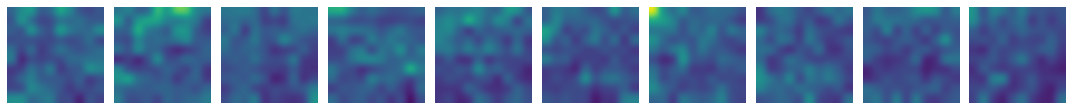

In [136]:
ex = df.iloc[0]
x = ex['X_video_same_length_normalized']

R, C = 1, 10
plt.figure(figsize=(15, 3))
vmin = x.min()
vmax = x.max()
for i in range(10):
    plt.subplot(R, C, i + 1)
    plt.imshow(x[i], vmin=vmin, vmax=vmax, interpolation='gaussian')
    plt.axis('off')

# fit the data

In [137]:
X = df[['X_video_same_length_normalized']] #.reshape(df_full.shape[0], 40, 10, 10)
y = df['Y_sig_mean_normalized'].values

In [138]:
# X_train = X[:10000]
# y_train = y[:10000]
X_train = X
y_train = y

In [146]:
dnn = neural_networks.neural_net_sklearn(track_name='X_video_same_length_normalized',
                                         arch='videonet',
                                         batch_size=2000,
                                         epochs=100)

In [ ]:
dnn.fit(X_train, y_train, device='cpu')

In [149]:
checkpoint_fname = '../models/dnn_video_net.pkl'
pkl.dump({'model_state_dict': dnn.model.state_dict()}, open(checkpoint_fname, 'wb'))

# transfer to classification

In [150]:
results = pkl.load(open('../models/dnn_video_net.pkl', 'rb'))
# results = pkl.load(open('../models/clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(track_name='X_video_same_length_normalized', arch='videonet')
dnn.model.load_state_dict(results['model_state_dict'])

<All keys matched successfully>

clath_aux+gak test 0.5220125786163522 0.6960167714884696
clath_aux+gak_a7d2 test 0.42686567164179107 0.663681592039801
clath_aux+gak_new test 0.3333333333333333 0.7282780410742496
clath_gak test 0.4761182714177407 0.711144806671721
clath_aux+gak train 0.591764705882353 0.7205882352941176
clath_aux+gak_a7d2 train 0.5047683923705722 0.6791553133514986
clath_aux+gak_new train 0.5183156453269429 0.7141389934953783
clath_gak train 0.4062005694400506 0.6605504587155964


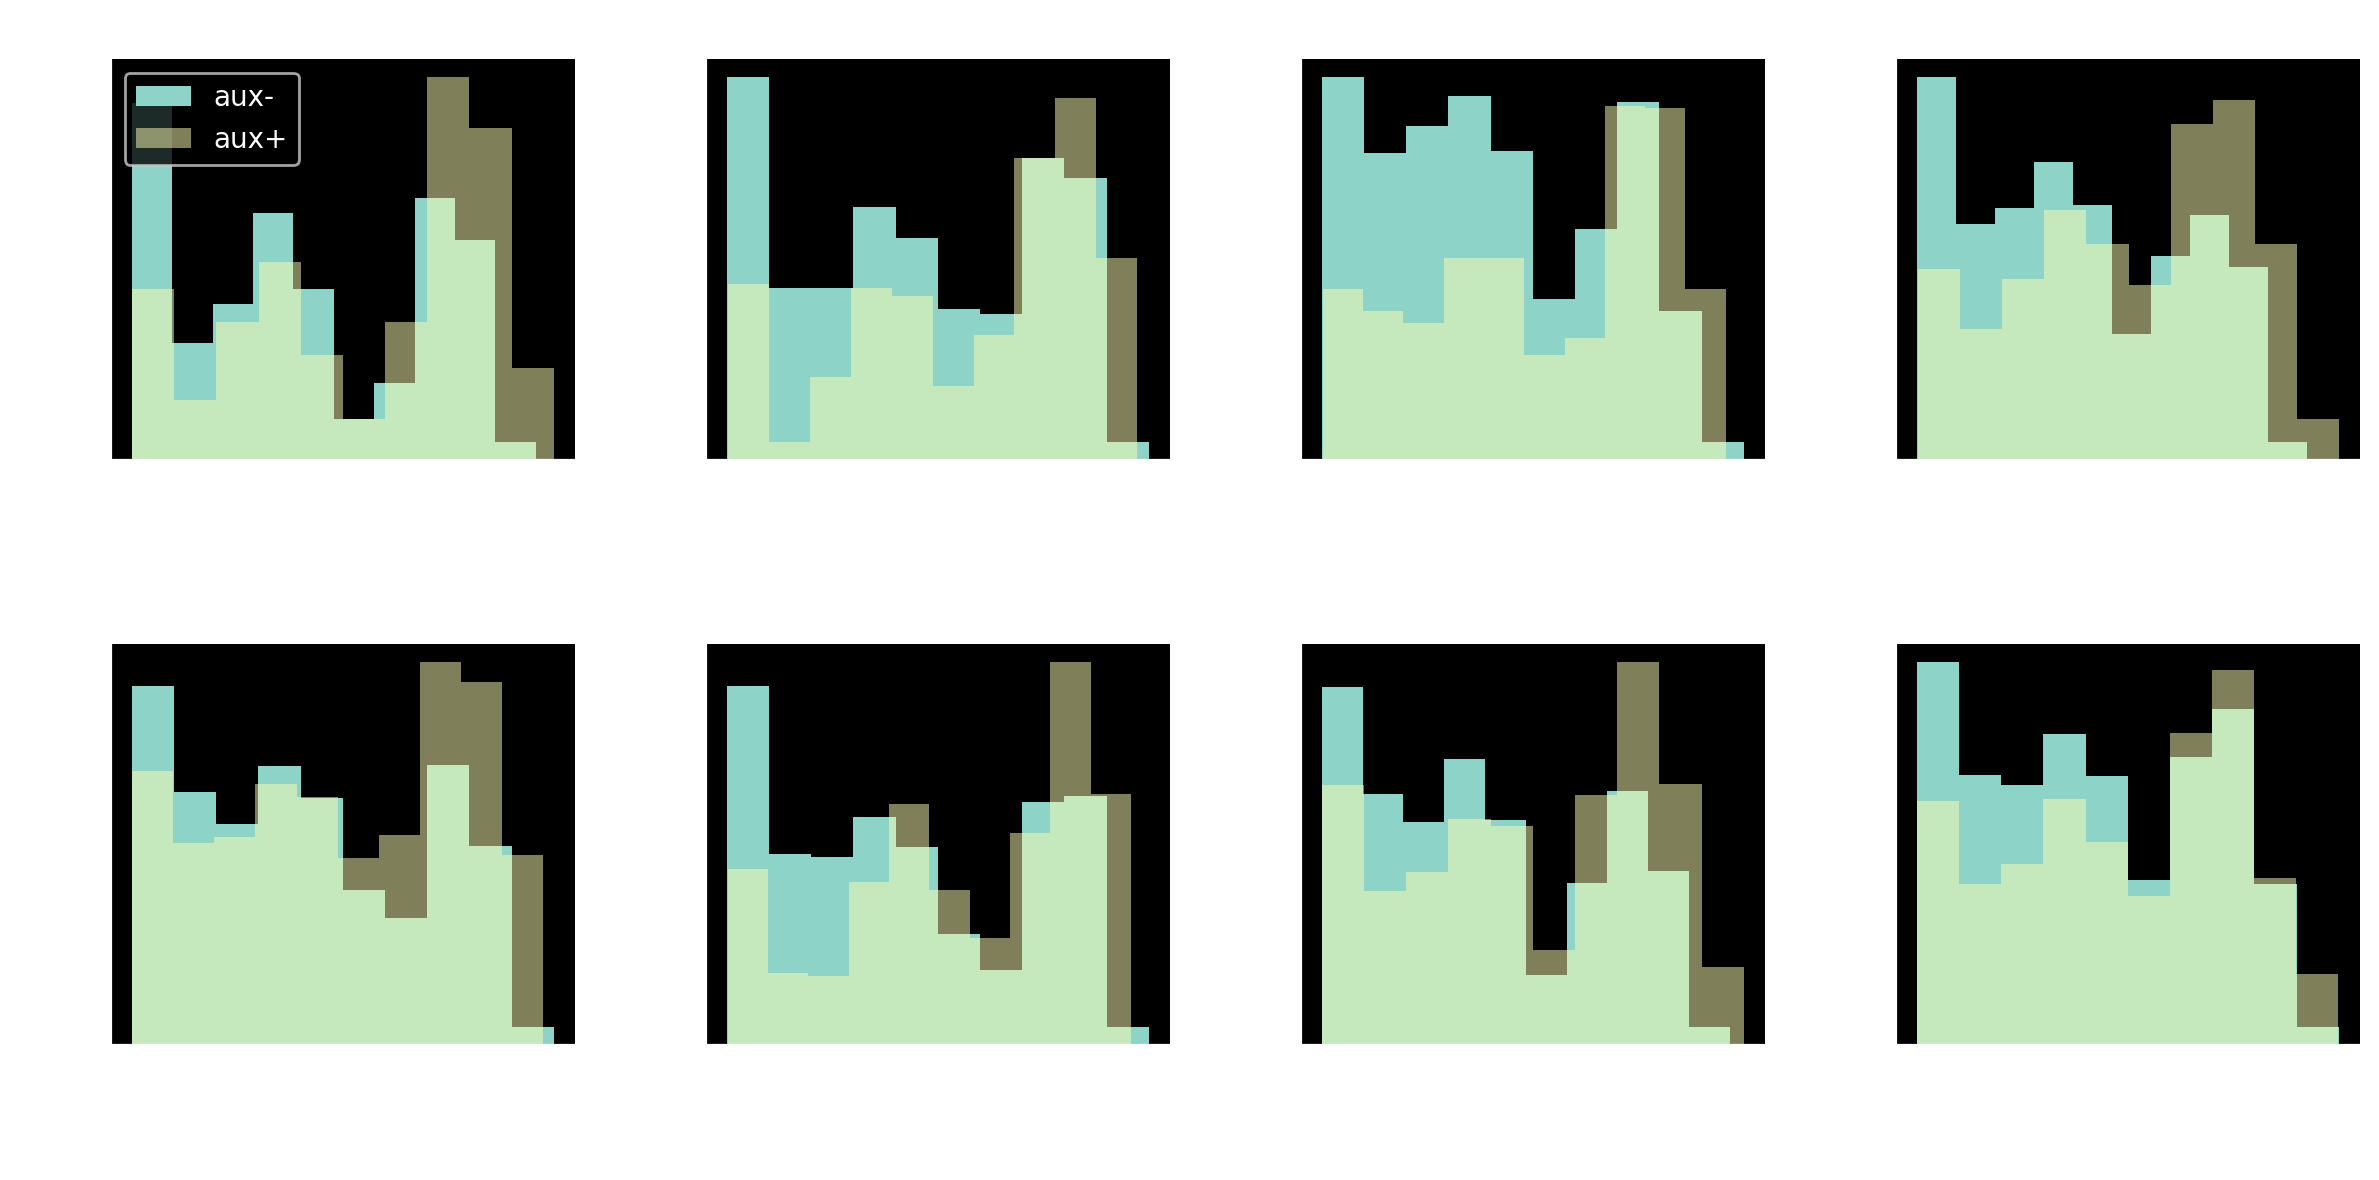

In [153]:
R = 2
C = len(dfs) // 2 - 1

# exclude the training data
ds = {(k, v): dfs[(k, v)]
      for (k, v) in sorted(dfs.keys(), key=lambda x: x[1] + x[0])
      if not k == 'clath_aux+gak_a7d2_new'}


plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, (k, v) in enumerate(ds.keys()):
    df = ds[(k, v)]
    X = df[['X_video_same_length_normalized']]
    y = df['y_consec_thresh']
    preds = dnn.predict(X)
    
    plt.subplot(R, C, i + 1)
    y_pred = (preds > 0).astype(int)
    acc = np.mean(y_pred == y)
    print(k, v, np.mean(y), acc)
    plt.title(f'{k} {v} {100*acc:0.1f}%', fontsize=10)
    plt.hist(preds[y==0], alpha=1, label='aux-')
    plt.hist(preds[y==1], alpha=0.5, label='aux+')
    plt.yscale('log')
    plt.xlabel('pred')
    
    if i == 0:
        plt.legend()

clath_aux+gak test
clath_aux+gak_a7d2 test
clath_aux+gak_new test
clath_gak test
clath_aux+gak train
clath_aux+gak_a7d2 train
clath_aux+gak_new train
clath_gak train


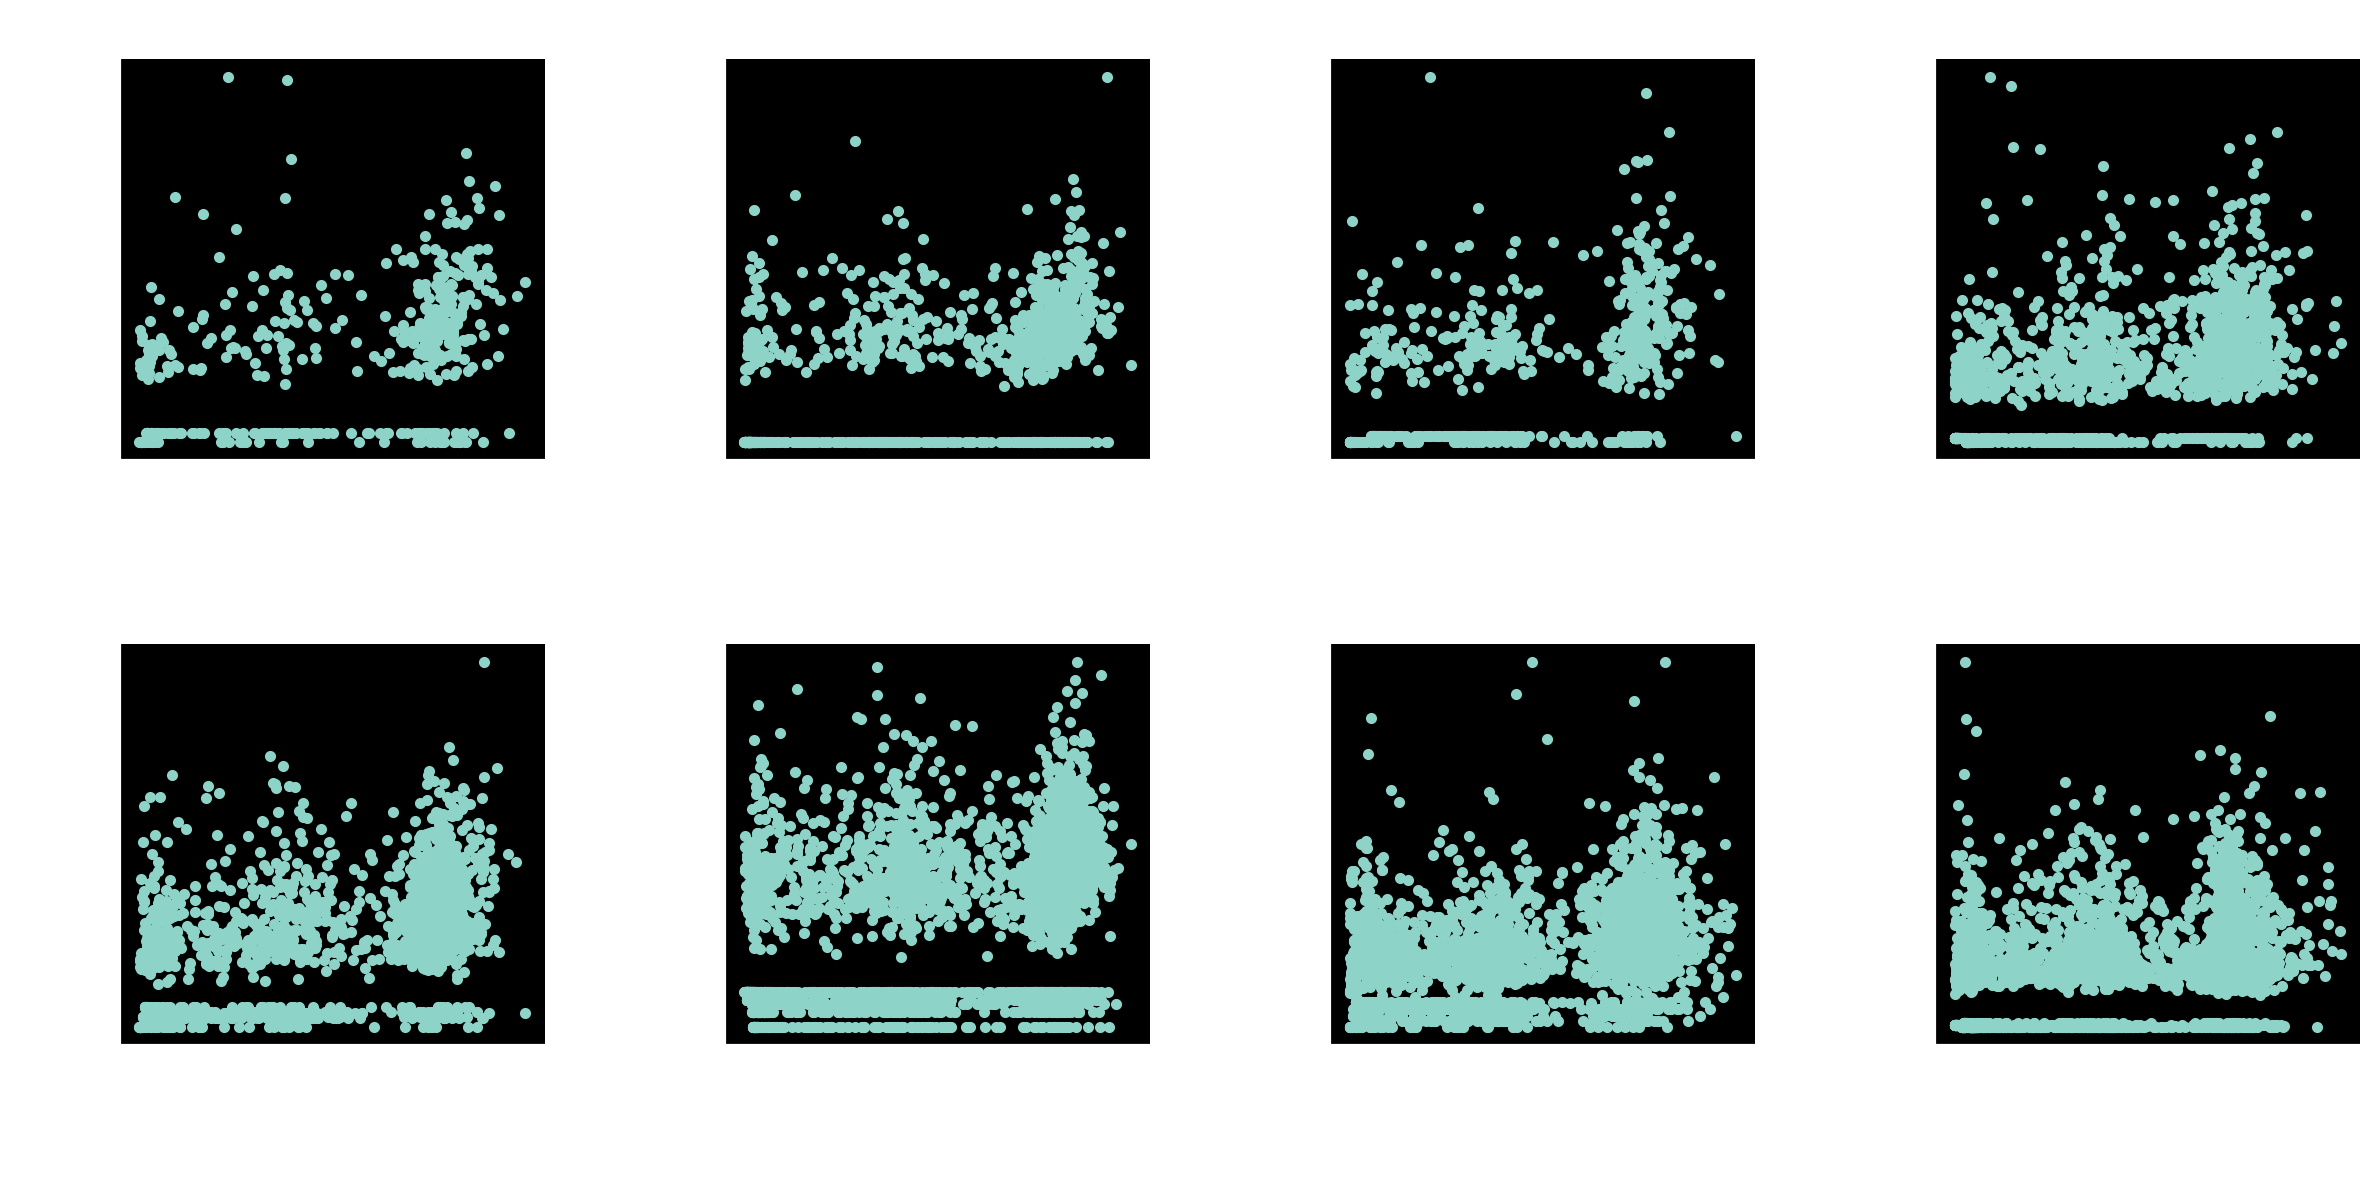

In [154]:
R = 2
C = len(dfs) // 2 - 1

plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, (k, v) in enumerate(ds.keys()):
    df = ds[(k, v)]
    X = df[['X_video_same_length_normalized']]
    y = df['Y_sig_mean_normalized']
    preds = dnn.predict(X)
    
    plt.subplot(R, C, i + 1)
    acc = np.corrcoef(preds, y)[0, 1]
    print(k, v) #, np.corrcoef(preds, y))
    plt.title(f'{k} {v} {100*acc:0.1f}', fontsize=10)    
    plt.plot(preds, df['Y_sig_mean_normalized'], '.')
    plt.xlabel('pred')
    plt.ylabel('aux_sig_mean')